<a href="https://colab.research.google.com/github/ashwingeeni12/data_science_fundamentals/blob/main/Unit_5/AshwinGeeni_U5Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro

For my project I am using a linear model to predict the performance of CPU based on the number of cores in a CPU. I will be doing this specifically for Desktop CPU's.

I got inspired to do this project because recently companies have been using something called power-efficent cores. Because these cores drive up core count, but have less performance that normal cores; I want to see how that effects the current relationship between CPU cores and performance.


*A core in a CPU is a physical processing unit that carries out instructions and performs calculations. A CPU can have multiple cores, and each core can handle its own tasks independently*

# Imports

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import xarray as xr
import pymc as pm

from scipy.interpolate import PchipInterpolator

#Data Sorting & How Data Looks

In [ ]:
#reading in csv from github
cpu_a= pd.read_csv("https://raw.githubusercontent.com/ashwingeeni12/data_science_fundamentals/refs/heads/main/Unit_5/CPU_benchmark_v4.csv")

#extracting only the columns i need
cpu_a = cpu_a[['cpuName', 'cpuMark', 'cores', 'category']]

#only using cpus that have a specified category
cpu_a = cpu_a.query('category != "Unknown"')

#this removes all entries with an empty entry
cpu_a.dropna(inplace=True)

In [ ]:
cpu_a

,cpuName,cpuMark,cores,category
0,AMD Ryzen Threadripper PRO 5995WX,108822,64,Desktop
1,AMD EPYC 7763,88338,64,Server
2,AMD EPYC 7J13,86006,64,Server
3,AMD EPYC 7713,85861,64,Server
4,AMD Ryzen Threadripper PRO 3995WX,83971,64,Desktop
...,...,...,...,...
3820,Intel Pentium 4 1.60GHz,84,1,Desktop
3821,Intel Pentium 4 1400MHz,83,1,Desktop
3822,Intel Pentium 4 1500MHz,81,1,Desktop
3823,VIA Eden 1000MHz,80,1,Laptop


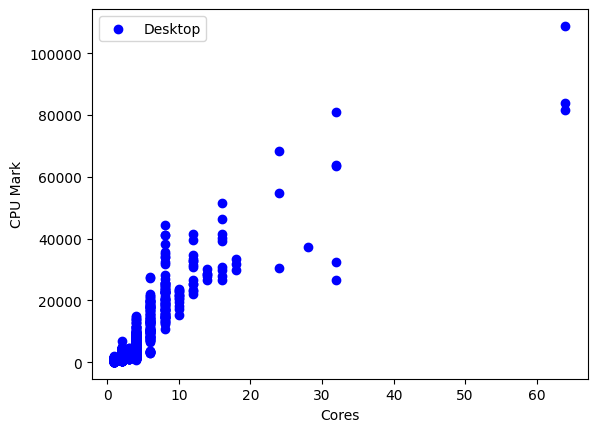

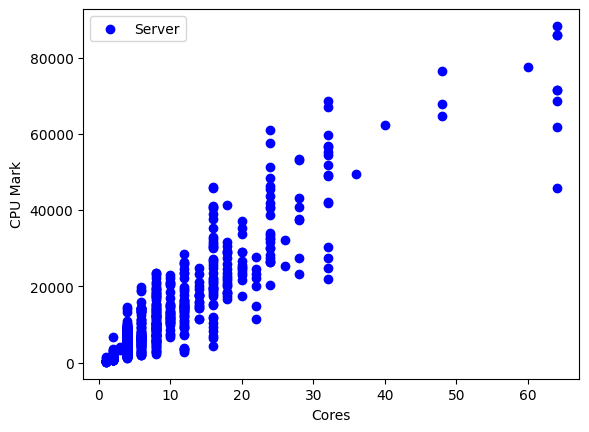

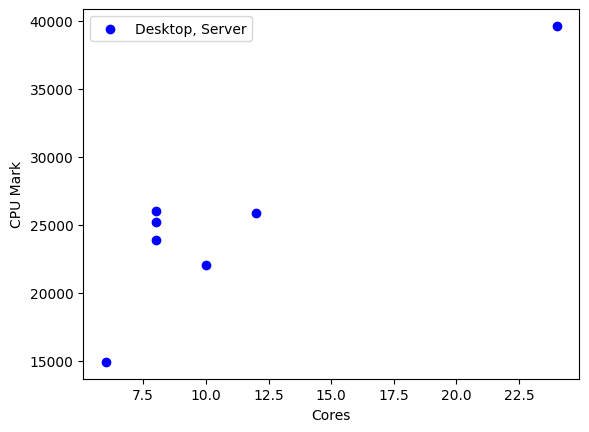

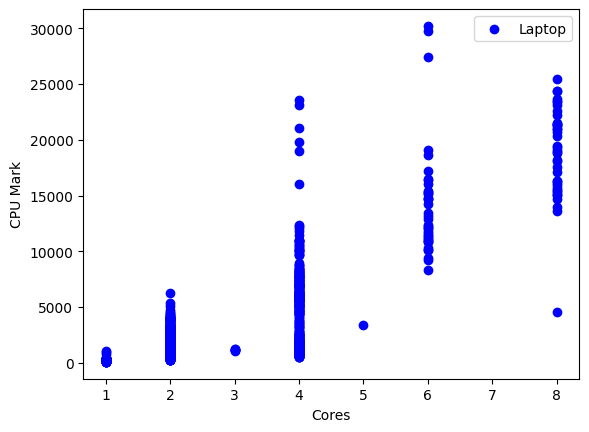

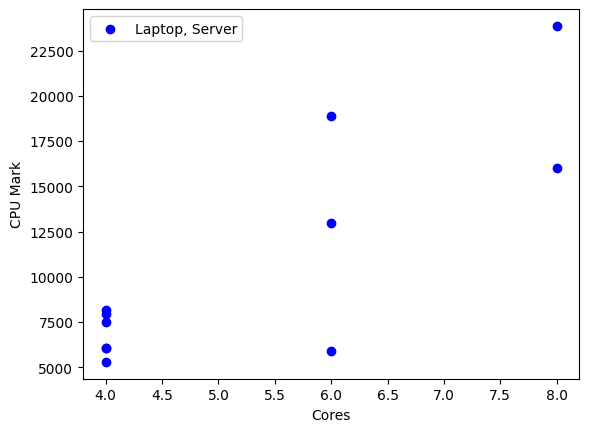

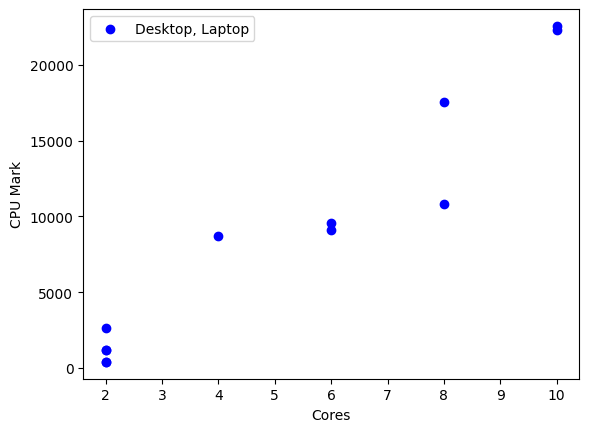

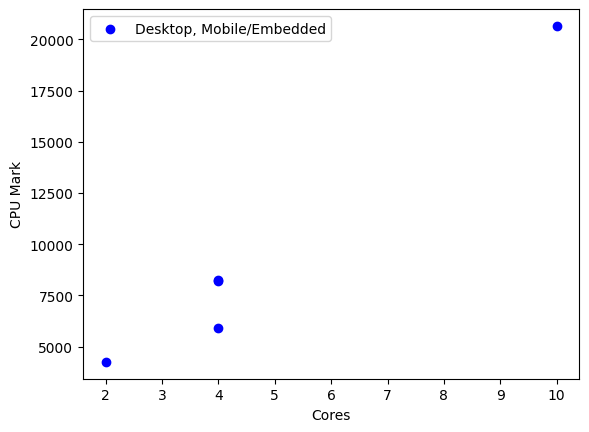

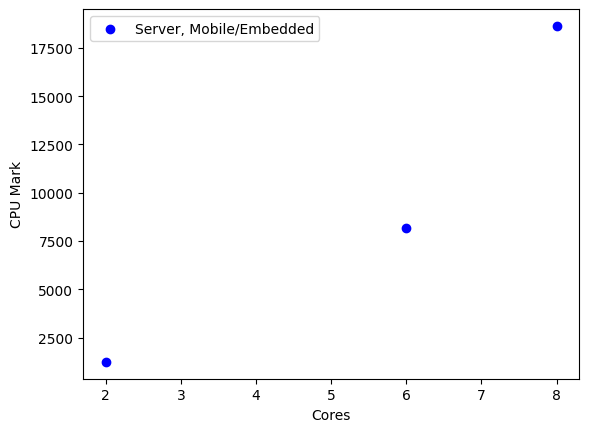

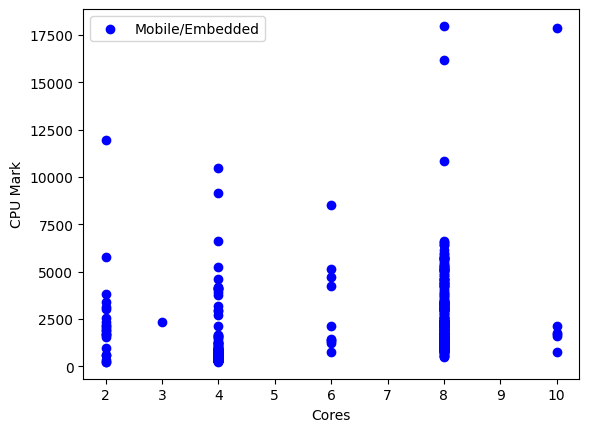

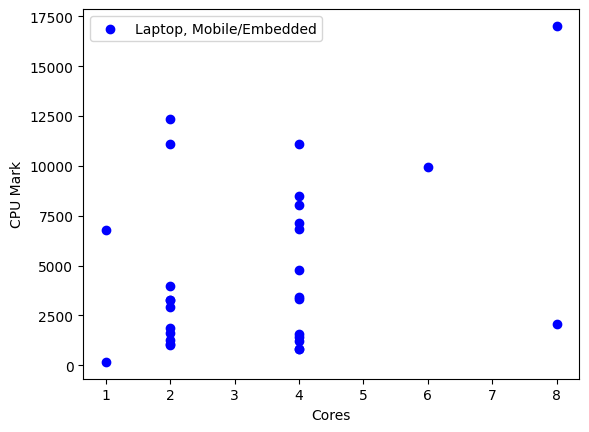

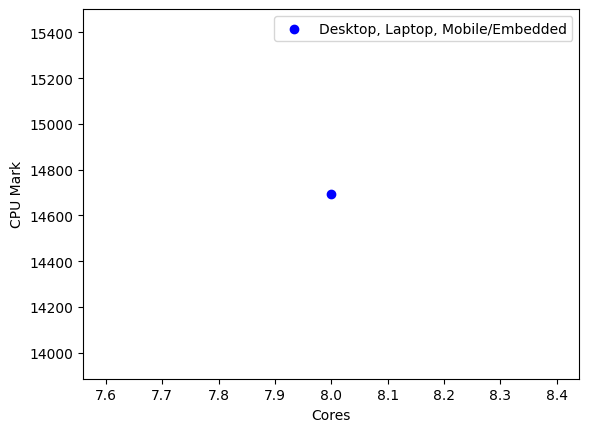

In [ ]:
#I am graphing all the different types of cpus to see the differences
formfactors = cpu_a["category"].unique()

for formfactor in formfactors:
    data = cpu_a[cpu_a["category"] == formfactor]
    plt.figure()
    plt.scatter(data["cores"], data["cpuMark"], color='blue', label=formfactor)
    plt.xlabel("Cores")
    plt.ylabel("CPU Mark")
    plt.legend()

I seperated by category and isolated to desktop to help limit variability, make my data more useful, and since it alligns with my context better.

In [ ]:
cpu_f = cpu_a.query('category == "Desktop"')

In [ ]:
cpu_f

,cpuName,cpuMark,cores,category
0,AMD Ryzen Threadripper PRO 5995WX,108822,64,Desktop
4,AMD Ryzen Threadripper PRO 3995WX,83971,64,Desktop
5,AMD Ryzen Threadripper 3990X,81568,64,Desktop
6,AMD Ryzen Threadripper PRO 5975WX,80842,32,Desktop
13,AMD Ryzen Threadripper PRO 5965WX,68405,24,Desktop
...,...,...,...,...
3819,Intel Pentium 4 1.70GHz,86,1,Desktop
3820,Intel Pentium 4 1.60GHz,84,1,Desktop
3821,Intel Pentium 4 1400MHz,83,1,Desktop
3822,Intel Pentium 4 1500MHz,81,1,Desktop


<Axes: xlabel='cores', ylabel='cpuMark'>

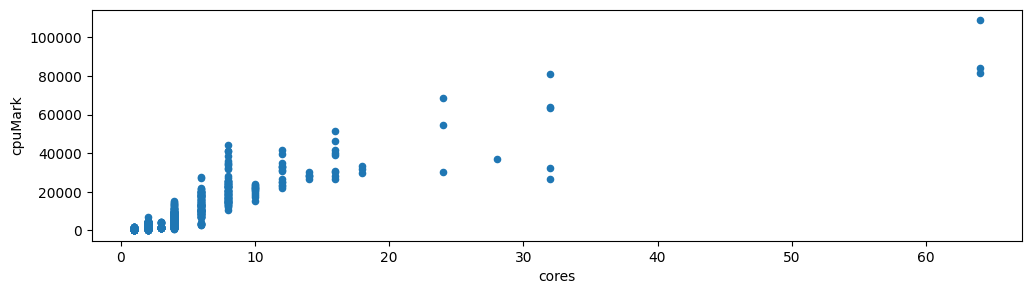

In [ ]:
cpu_f.plot(x="cores", y="cpuMark", figsize=(12, 3), kind="scatter")

From here we can see there defintely is a positive relationship between CPU cores and performance, but there is also a ton of variability and increases in performance between core counts decreases with more cores

# My First Model

This model was super simple, just using the same priors as the exercises, but with some adjustments to the values to fit the range of my data set. These priors are pretty broad, so I am not expecting too much out of this model, but will serve as a good baseline.



In [ ]:
with pm.Model() as model_one:

    α = pm.Normal("α", mu=0, sigma=10000)
    β = pm.Normal("β", mu=0, sigma=1000)

    μ = pm.Deterministic("μ", α + β * cpu_f.cores)

    σ = pm.HalfCauchy("σ", 10)

    y_pred = pm.HalfStudentT("y_pred", sigma=μ, nu=σ, observed=cpu_f.cpuMark)

    idata_one = pm.sample()

Output()

Output()

ERROR:pymc.stats.convergence:There were 373 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Text(0, 0.5, 'cpuMark')

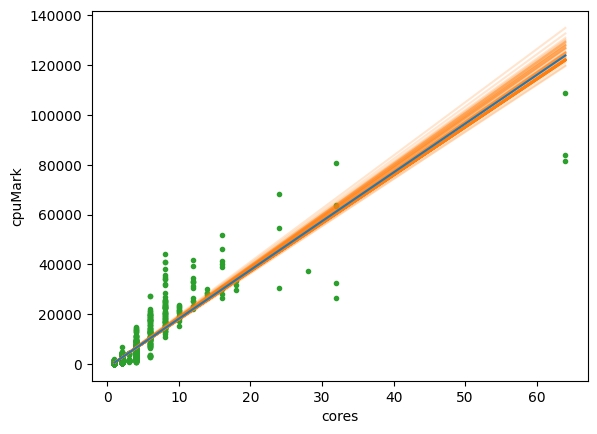

In [ ]:
posterior = az.extract(idata_one, num_samples=100)

x_plot = xr.DataArray(
    np.linspace(cpu_f.cores.min(), cpu_f.cores.max(), 50),
    dims="plot_id"
    )

mean_line = posterior["α"].mean() + posterior["β"].mean() * x_plot

lines = posterior["α"] + posterior["β"] * x_plot

_, ax = plt.subplots()

ax.plot(x_plot, lines.T, c="C1", alpha=0.2, label="lines")

ax.plot(x_plot, mean_line, c="C0", label="mean line")

ax.plot(cpu_f.cores, cpu_f.cpuMark, "C2.", zorder=-3)

ax.set_xlabel("cores")
ax.set_ylabel("cpuMark")

In [ ]:
pm.sample_posterior_predictive(idata_one, model=model_one,  extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

(0.0, 150000.0)

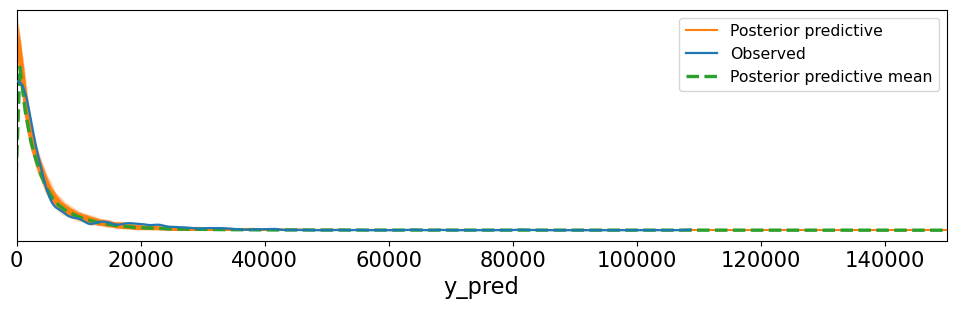

In [ ]:
ax = az.plot_ppc(idata_one, num_pp_samples=200, colors=["C1", "C0", "C2"], figsize=(12, 3))
ax.set_xlim(0, 150000)

(0.0, 20000.0)

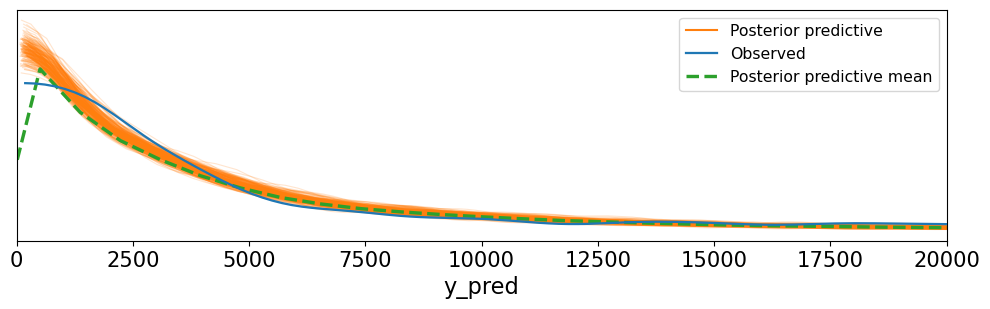

In [ ]:
ax = az.plot_ppc(idata_one, num_pp_samples=200, colors=["C1", "C0", "C2"], figsize=(12, 3))
ax.set_xlim(0, 20000)

The model does good in capturing the general trend between the number of cores and the cpu performance, as the posterior predictive mean follows the observed data well. However, it struggles with outliers and does not predict extreme values well, as shown in the model visualization. So maybe we can try to incorporate skew into the model.

# My Second Model

In [ ]:
with pm.Model() as model_two:

    #priors for the linear part of our model
    α = pm.Normal("α", mu=0, sigma=10000)
    β = pm.Normal("β", mu=0, sigma=1000)

    #this is the linear part of our model
    μ = pm.Deterministic("μ", α + β * cpu_f.cores)

    #prior for the standard deviation of our likelihood
    #Cauchy is a T dist with nu = 1
    σ = pm.HalfCauchy("σ", 1000)
    ν = pm.Normal("ν", mu = 10, sigma = 1)
    Β = pm.Normal("Β", mu = 100, sigma = 10)
    #likelihood
    y_pred = pm.SkewStudentT("y_pred", mu=μ, sigma = σ, a = ν, b = Β,   observed=cpu_f.cpuMark)

    #inference data object
    idata_two = pm.sample()

Output()

Output()

Text(0, 0.5, 'cpuMark')

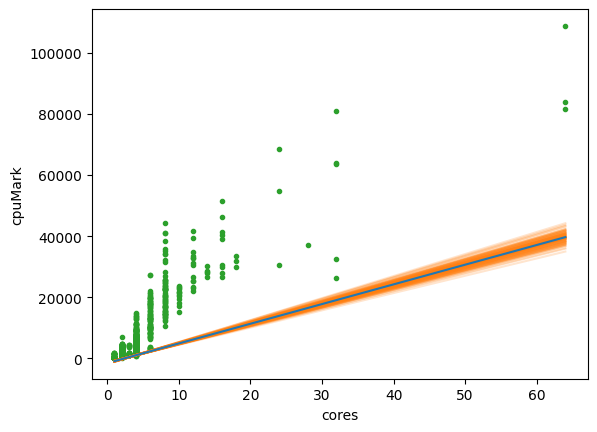

In [ ]:
posterior = az.extract(idata_two, num_samples=100)

x_plot = xr.DataArray(
    np.linspace(cpu_f.cores.min(), cpu_f.cores.max(), 50),
    dims="plot_id"
    )

mean_line = posterior["α"].mean() + posterior["β"].mean() * x_plot

lines = posterior["α"] + posterior["β"] * x_plot

_, ax = plt.subplots()

ax.plot(x_plot, lines.T, c="C1", alpha=0.2, label="lines")

ax.plot(x_plot, mean_line, c="C0", label="mean line")

ax.plot(cpu_f.cores, cpu_f.cpuMark, "C2.", zorder=-3)

ax.set_xlabel("cores")
ax.set_ylabel("cpuMark")

In [ ]:
pm.sample_posterior_predictive(idata_two, model=model_two,  extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

(0.0, 150000.0)

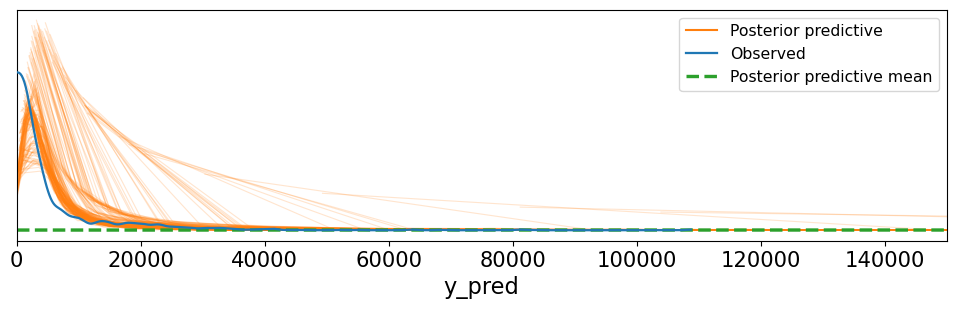

In [ ]:
ax = az.plot_ppc(idata_two, num_pp_samples=200, colors=["C1", "C0", "C2"], figsize=(12, 3))
ax.set_xlim(0, 150000)

(60000.0, 150000.0)

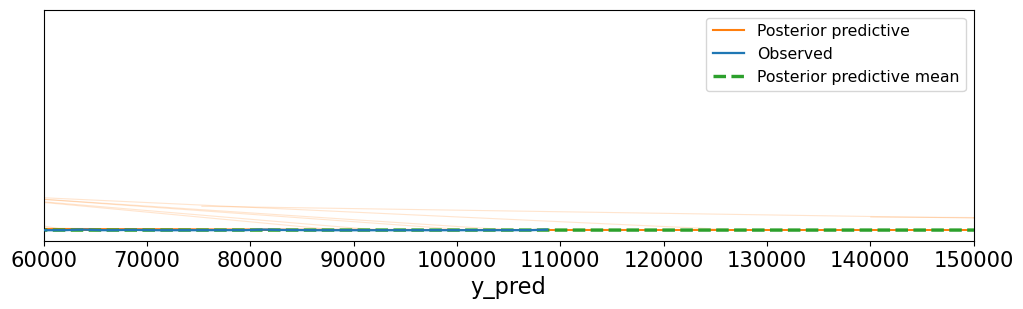

In [ ]:
ax = az.plot_ppc(idata_two, num_pp_samples=200, colors=["C1", "C0", "C2"], figsize=(12, 3))
ax.set_xlim(60000, 150000)

The model does a horrible job in capturing the general trend between the number of cores and the cpu performance, as the posterior predictive mean doesn't fit the observed at the beginning, while at the end it does. This could be due to the model being made for the purpose of representing outliers well. In the model visualization it has too small of a slope as well, so it doesn't follow the general trend that well.

After talking to Mr.A he suggested using a log and using a liner model to represent my variance.

# Model Three, The Final One

In [ ]:
with pm.Model() as model_three:
    α = pm.Normal("α", mu=0, sigma=5000)
    β = pm.Normal("β", mu=2000, sigma=500)
    a = pm.Normal("a", mu=1000, sigma = 5)
    b = pm.Normal("b", mu=200, sigma = 10)

    μ = pm.Deterministic("μ", np.log(α + β * cpu_f.cores))
    σ = pm.Deterministic("σ", a + b * cpu_f.cores)

    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=cpu_f.cpuMark)

    # Sampling
    idata_three = pm.sample()

Output()

Output()

ERROR:pymc.stats.convergence:There were 765 divergences after tuning. Increase `target_accept` or reparameterize.


In [ ]:
pm.sample_posterior_predictive(idata_three, model=model_three,  extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

Text(0, 0.5, 'cpuMark')

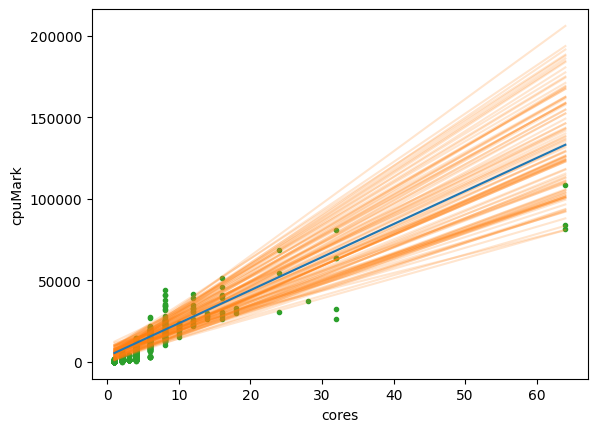

In [ ]:
#grabs 100 posterior samples
posterior = az.extract(idata_three, num_samples=100)

# grabbing x values for graphing.
x_plot = xr.DataArray(
    np.linspace(cpu_f.cores.min(), cpu_f.cores.max(), 50),
    dims="plot_id"
    )

mean_line = posterior["α"].mean() + posterior["β"].mean() * x_plot

lines = posterior["α"] + posterior["β"] * x_plot

#set up plot
_, ax = plt.subplots()

#plots 50 other lines our model came up with.
ax.plot(x_plot, lines.T, c="C1", alpha=0.2, label="lines")

#plots the mean line
ax.plot(x_plot, mean_line, c="C0", label="mean line")

#plot the raw data
ax.plot(cpu_f.cores, cpu_f.cpuMark, "C2.", zorder=-3)

#label axes and create legend
ax.set_xlabel("cores")
ax.set_ylabel("cpuMark")

(0.0, 150000.0)

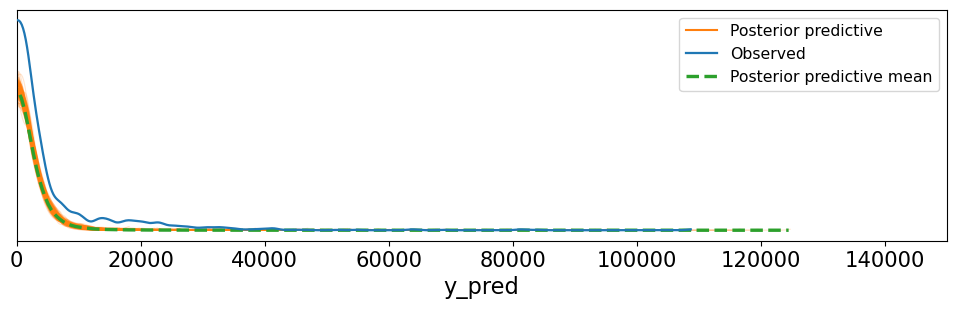

In [ ]:
ax = az.plot_ppc(idata_three, num_pp_samples=200, colors=["C1", "C0", "C2"], figsize=(12, 3))
ax.set_xlim(0, 150000)

The model does a alright job in capturing the general trend between the number of cores and the cpu performance, as the posterior predictive mean doesn't fit the observed at the beginning as well as it is lower than it is supposed to be, while at the end it does. In the model visualization it follows the general trend decently well, and it is interesting to see how since the variance is increasing lineraly, which helps make the mean line allign with the general trend better.

# Conclusions


**Which One is The Best Model**

Based on the context of CPU cores versus CPU performance, Model 3 is the best model,  because CPU performance (cpuMark) is often highly skewed because of all the different types of CPU's with the same amount of cores, which aligns well with the assumptions of a LogNormal distribution. The log-transformation in Model 3 captures the exponentialness of how performance increases as cores increase, making it better for cases where performance does not scale linearly but rather increases in a more exponential way as cores add up. Additionally, Model 2 accounts for growing variability with more cores by modeling the standard deviation (σ) as linearly increasing of cores. While Model 1 uses a Half-Student T distribution, which could handle heavy-tailed outliers better, it doesn't capture the pattern of performance seen with increasing cores as effectively as Model 2 does. Therefore, Model 2 provides a better fit for CPU performance relative to the number of cores.

**Cool Stuff I learned**

Firstly, the CPU performance (y-axis) increases with the number of cores (x-axis), which is expected; however, there seems to be a step-like increase in performance, particularly between lower core counts (0-10 cores) and higher core counts (30-60 cores). This could suggest that each additional core providing less incremental improvement as cores increase. A potential surprise is the presence of extreme outliers in the higher end of the core count (around 50+ cores), with CPU performance sharply jumping for a few data points. This could be indicative of more specialized processors, such as those designed for high-performance or multi-threaded tasks.

An interesting feature in this data might also be the presence of Apple's M1 chips, which are known for their efficiency cores. The M1 architecture includes a mix of high-performance and power-efficient cores, which can lead to an increase in overall performance without linearly scaling with core count. This is particularly evident in processors with lower core counts (around 8 to 16 cores), where the performance is much higher than expected based on a typical scaling model, demonstrating Apple's efficient use of power-efficient cores in boosting performance. The M1’s architecture, with its focus on power efficiency, could explain the steep jumps in performance for CPUs with relatively fewer cores. As other companies continue to adopt this model we could see similar trends occur.

**Real Life?**

The model reflects the general exponential increase in performance with core count, which is true for many modern CPUs, especially those designed for multithreading. However, it may not fully capture certain things, such as adding more cores leads to progressively smaller improvements. Additionally, the model may overlook architectural differences, like Apple's M1 chips, which use a combination of performance and efficiency cores that provide higher performance per core, making the relationship between core count and performance non-linear. The model also doesn't fully account for outliers in the dataset, which could be special-purpose, high-core-count CPUs that don't behave the same way as consumer-grade processors. So while the model represents a good chunk of the data pretty well, there are lots of specific use cases that it doesn't represent well, and with the addition of power efficient cores to CPU's the model won't be able to represent that future as well.